# AR モデル

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# comment out below
import json
def dict2rc(dict): return {f'{k1}.{k2}': v for k1,d in dict.items() for k2, v in d.items()}
with open('mpl_rc.json') as f:
    plt.rcParams.update(dict2rc(json.load(f)))
plt.style.use('dracula')

## 課題1：ARモデルの実装

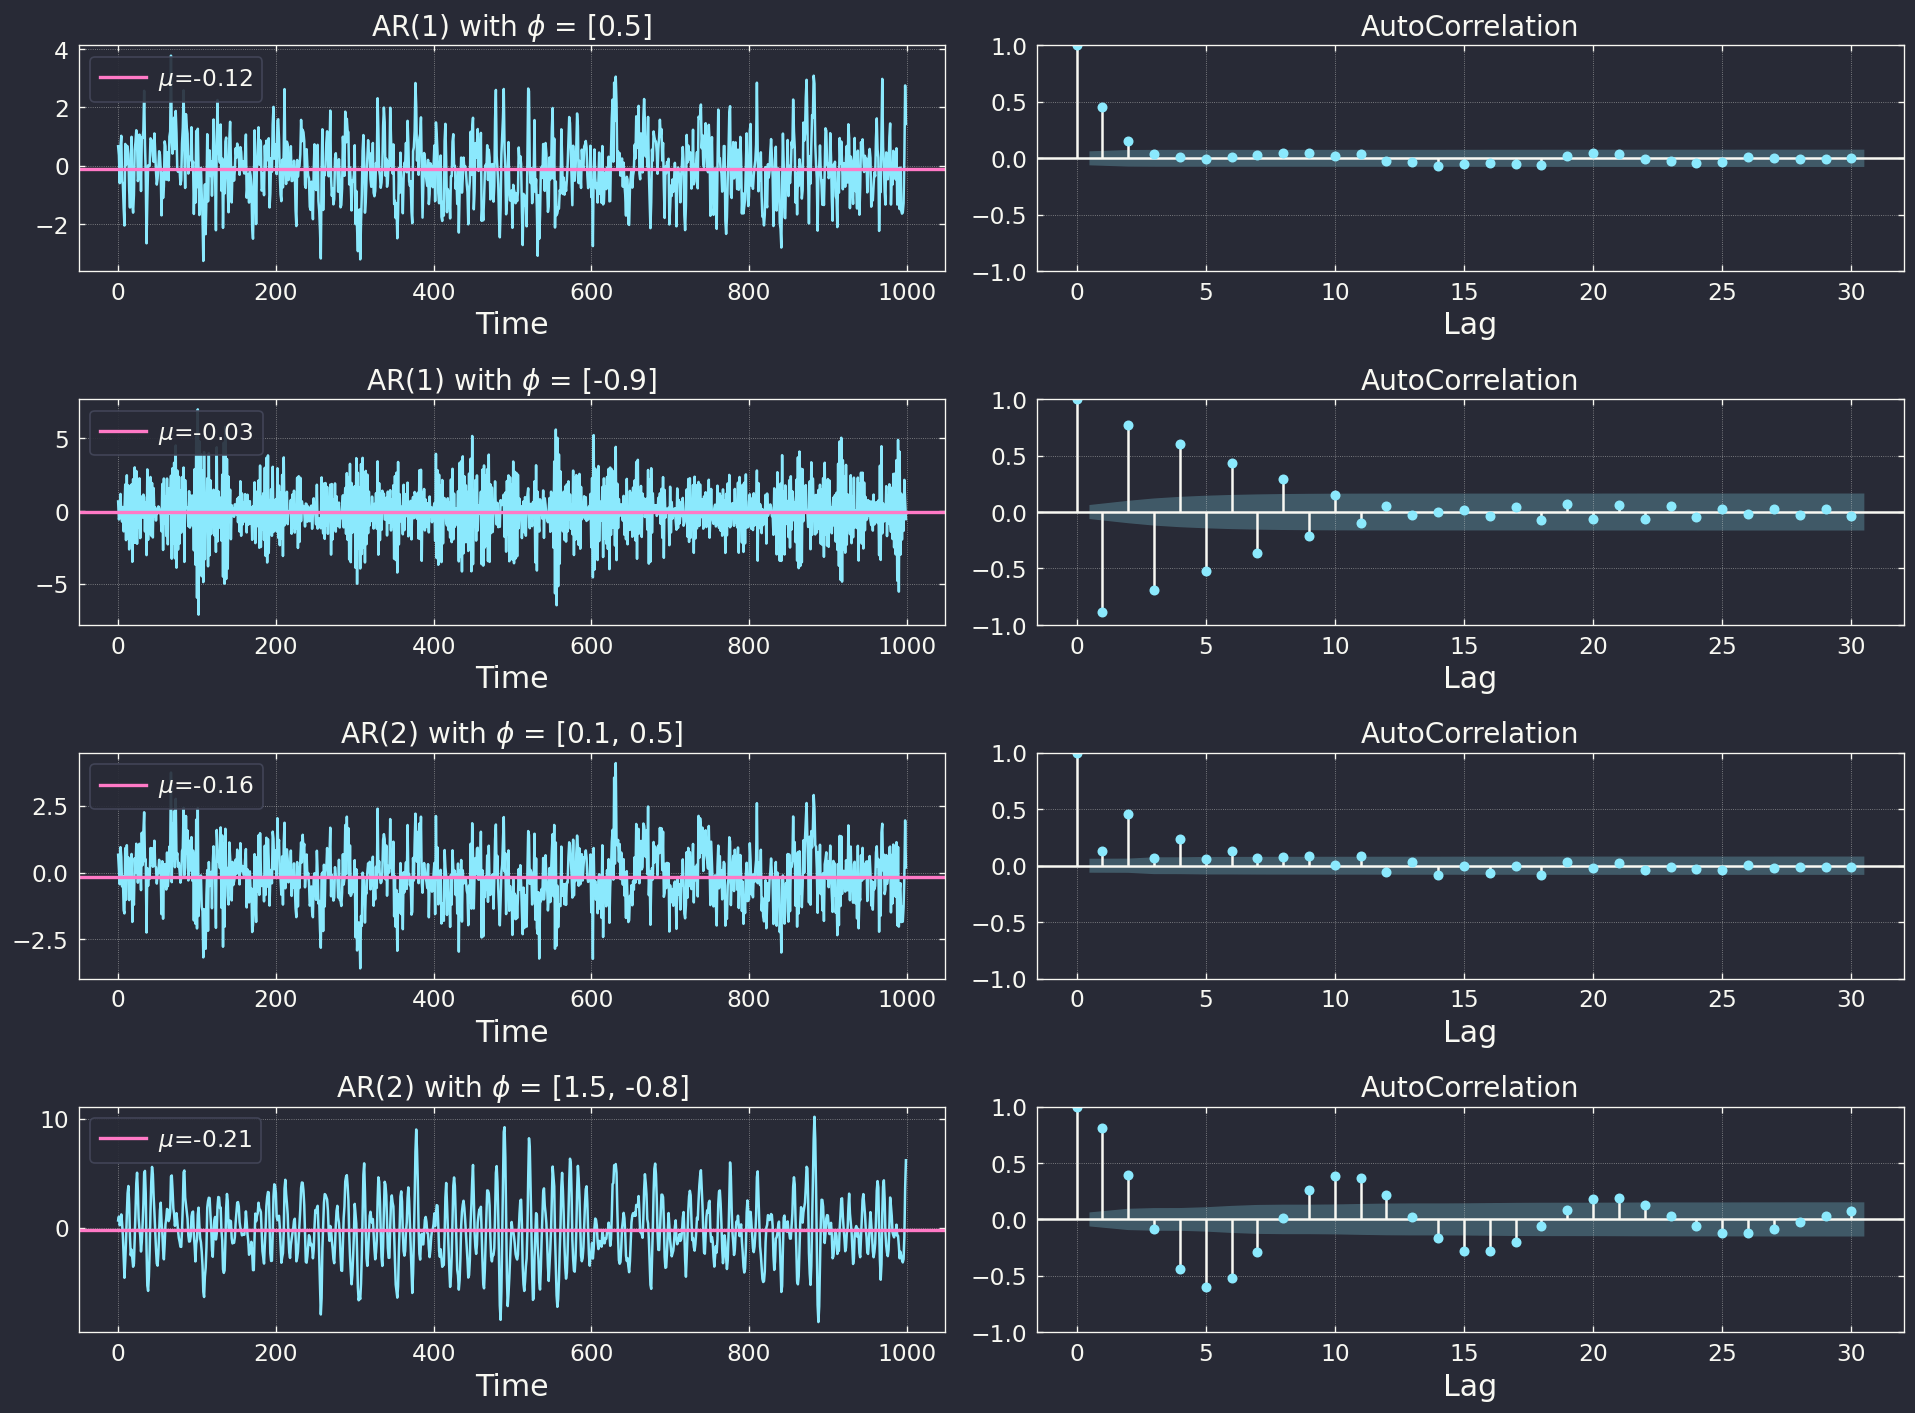

In [34]:
# AR的な時系列を生成
def generate_ar_time_series(T, coefs, sigma=1.0, seed=23):
    # coef: AR(p)のパラメータ; p=len(coefs)
    # sigma: WN(sigma^2); ここでは正規乱数を使う

    if not isinstance(coefs, np.ndarray):
        coefs = np.array(coefs)

    p = len(coefs)
    np.random.seed(seed)
    x = np.random.normal(loc=0, scale=sigma, size=T)
    for t in range(1,T):
        x[t] += np.sum(coefs[min(t,p)-1::-1] * x[max(0,t-p):t])
    return x

# 自己共分散を計算
def calc_auto_cov(x, p):
    auto_cov = np.zeros(p+1)
    T = len(x)
    auto_cov[0] = np.sum(x * x) / (T-1)
    for i in range(1, p+1):
        auto_cov[i] = np.sum(x[i:] * x[:-i]) / (T-i)
    return auto_cov

# 課題1
def main():
    _, axes = plt.subplots(4,2,figsize=(16,12))
    T = 1000
    lst_coefs = [
        [0.5],
        [-0.9],
        [0.1,0.5],
        [1.5,-0.8]
    ]
    for i, coefs in enumerate(lst_coefs):
        x = generate_ar_time_series(T, coefs, sigma=1)
        ax = axes[i,0]
        ax.plot(x)
        mu = np.mean(x)
        ax.axhline(mu, c='C1', lw=2, label=f'$\mu$={mu:.2f}')
        ax.legend(loc='upper left')
        ax.set_xlabel('Time')
        ax.set_title(f'AR({len(coefs)}) with $\phi$ = {coefs}')
        
        ax = axes[i,1]
        p = 20
        # plot_acf(x, ax=ax, lags=p)
        auto_cov = calc_auto_cov(x, p)
        ax.stem(range(p+1), auto_cov / auto_cov[0], 
                markerfmt='C0', linefmt='white', basefmt='white')
        ax.set_xlabel('Lag')
        ax.set_title('AutoCorrelation')

    plt.tight_layout()

main()

## 課題2：ARモデルのパラメータ推定

Yule-walker法を使う

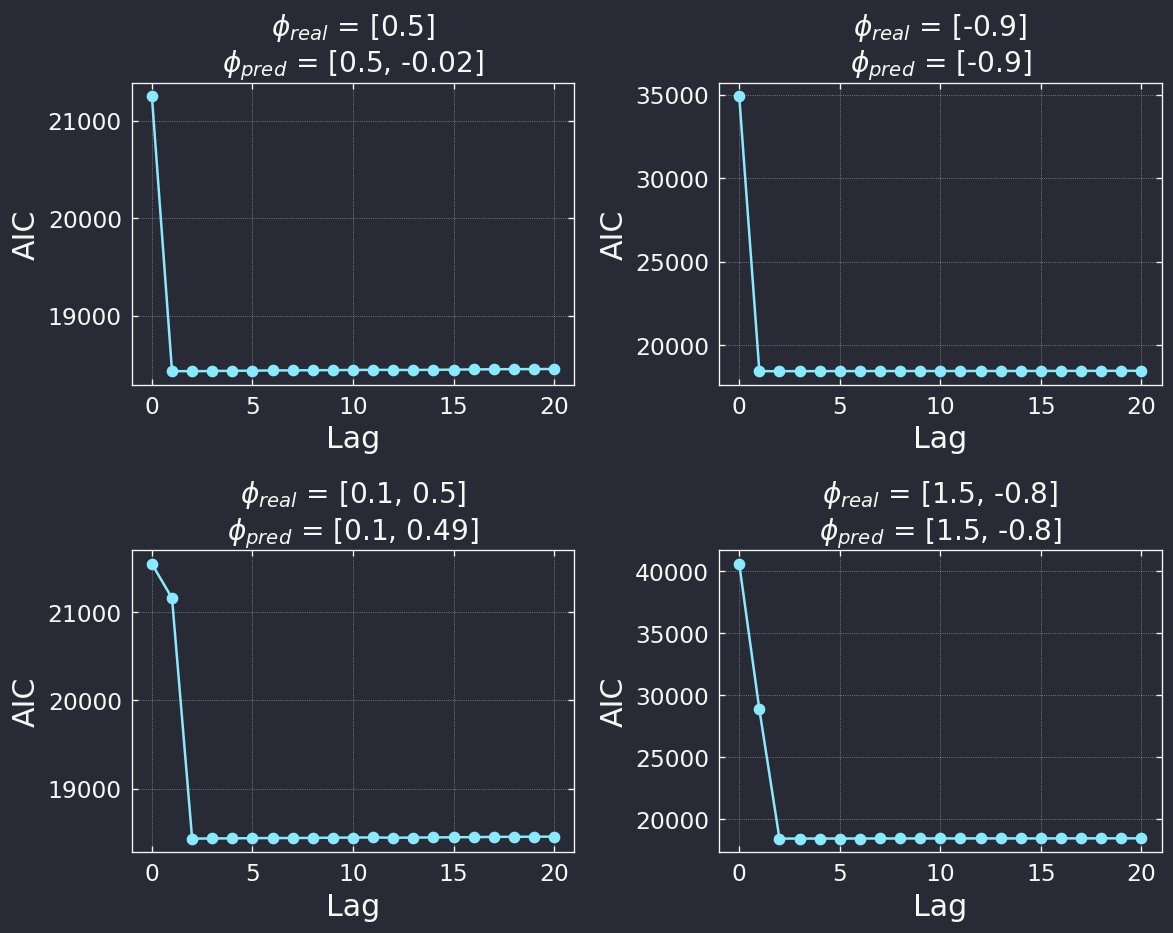

In [23]:
def calc_auto_cov(x, p):
    auto_cov = np.zeros(p+1)
    T = len(x)
    auto_cov[0] = np.sum(x * x) / (T-1)
    for i in range(1, p+1):
        auto_cov[i] = np.sum(x[i:] * x[:-i]) / (T-i)
    return auto_cov

def centering(x):
    return x - np.mean(x)


def levinson(x, p):
    y = centering(x)
    auto_cov = calc_auto_cov(y, p) # (p+1)次元: 0,1,...,p

    coefs = np.zeros((p+1,p)) # ARの係数
    vars = np.zeros(p+1) # WNの分散

    # Lag = 0
    vars[0] = auto_cov[0]

    # Lag = 1
    coefs[1,0] = auto_cov[1] / vars[0]
    vars[1] = (1 - coefs[1,0]**2) * vars[0]

    # Lag = 2,...,p
    for i in range(2,p+1):
        phi_p = ( auto_cov[i] - np.convolve(coefs[i-1,:i-1], auto_cov[1:i], mode='valid')[0] ) / vars[i-1]

        coefs[i,i-1] = phi_p
        for j in range(i-1):
            coefs[i,j] = coefs[i-1,j] - coefs[i-1, i-j-2] * phi_p
        vars[i] = (1 - phi_p**2) * vars[i-1]

    return coefs, vars

# 課題2
def main():
    T = 10000
    lst_coefs = [
        [0.5],
        [-0.9],
        [0.1,0.5],
        [1.5,-0.8]
    ]

    _, axes = plt.subplots(2,2,figsize=(10,8))
    axes = axes.flatten()

    for i, coefs in enumerate(lst_coefs):
        x = generate_ar_time_series(T, coefs, sigma=1)
        p = 20
        estimated_coefs, vars = levinson(x, p)

        l = np.log(2*np.pi*vars)
        aic = T*l + 2*(np.arange(p+1) + 2)

        opt_p = np.argmin(aic)
        round2 = lambda x: np.round(x, 2)
        title = '$\phi_{real}$ = ' + f'{coefs}'
        title += '\n$\phi_{pred}$ = ' + f'{list(map(round2, list(estimated_coefs[opt_p,:opt_p])))}'

        ax = axes[i]
        ax.plot(aic, marker='o')
        ax.set_title(title)
        ax.set_xlabel('Lag')
        ax.set_ylabel('AIC')

    plt.tight_layout()

main()

## 課題3：ランダム乗算過程

100%|██████████| 999/999 [00:05<00:00, 187.06it/s]


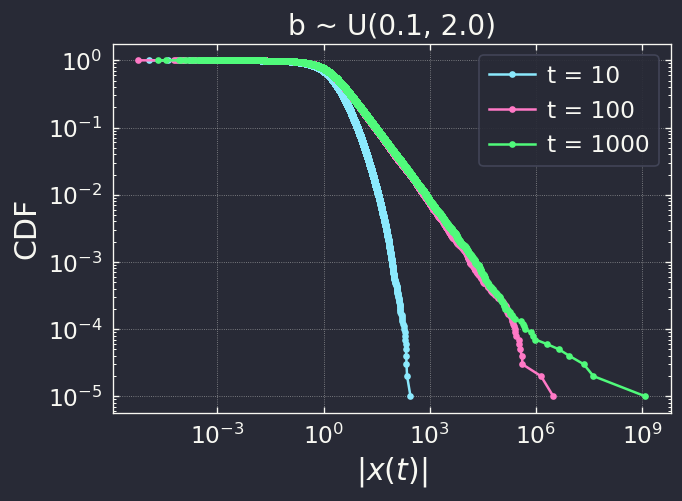

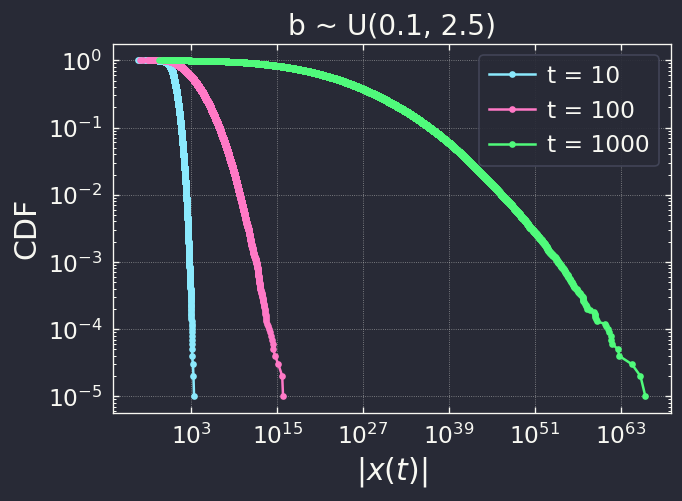

In [5]:
def RMP(N=10000, T=1000, bmin=0.1, bmax=2.0):
    b = np.random.uniform(bmin,bmax,(N,T))
    x = np.random.normal(0,1,(N,T))
    for t in trange(T-1):
        x[:,t+1] += b[:,t] * x[:,t]
    return x


def draw_cdf(X, title=None):
    # X: (N,T)
    n = X.shape[0]
    cdf = [(i+1)/n for i in range(n)]

    plt.figure()
    for t in [10,100,1000]:
        plt.plot(sorted(np.abs(X[:,t-1]), reverse=True), cdf, 
                 marker='o', ms = 3,
                 label=f't = {t}')
    plt.xlabel('$|x(t)|$')
    plt.ylabel('CDF')
    if title: plt.title(title)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()


def main():
    bmin, bmax = 0.1, 2.0
    X0 = RMP(N=100000, T=1000, bmin=bmin, bmax=bmax)
    draw_cdf(X0, title=f'b ~ U({bmin}, {bmax})')
    del X0

    bmin, bmax = 0.1, 2.5
    X1 = RMP(N=100000, T=1000, bmin=bmin, bmax=bmax)
    draw_cdf(X1, title=f'b ~ U({bmin}, {bmax})')
    del X1

main()